In this post, I will demonstrate how you can use [emcee](https://emcee.readthedocs.io/en/latest/) to sample models defined using [PyMC3](https://docs.pymc.io/).
Thomas Wiecki [wrote about how to do this this with an earlier version of PyMC](http://twiecki.github.io/blog/2013/09/23/emcee-pymc/), but I needed an update since I wanted to do a comparison and PyMC's interface has changed a lot since he wrote his post.
This isn't necessarily something that you'll *want* to do (and I definitely don't recommend it in general), but I figured that I would post it here for posterity.

For simplicity, let's use the simulated data from my [previous blog post](/posts/pymc-tensorflow):

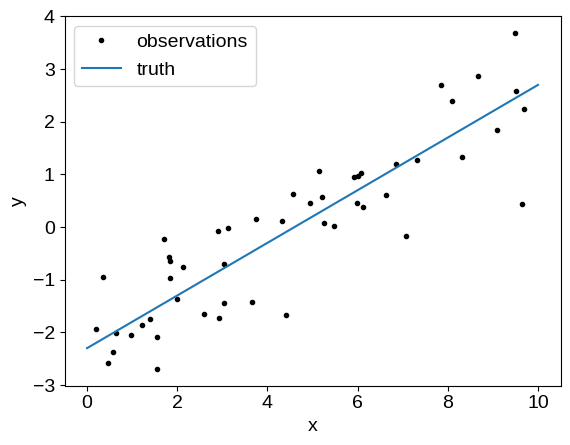

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

true_params = np.array([0.5, -2.3, -0.23])

N = 50
t = np.linspace(0, 10, 2)
x = np.random.uniform(0, 10, 50)
y = x * true_params[0] + true_params[1]
y_obs = y + np.exp(true_params[-1]) * np.random.randn(N)

plt.plot(x, y_obs, ".k", label="observations")
plt.plot(t, true_params[0] * t + true_params[1], label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=14);

Then, we can code up the model in PyMC3 following [Jake VanderPlas' notation](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/), and sample it using PyMC3's NUTS[sic] sampler:

In [2]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    logs = pm.Normal("logs", mu=0.0, sigma=3.0)
    alphaperp = pm.Normal("alphaperp", mu=0.0, sigma=3.0)
    theta = pm.Uniform("theta", -np.pi, np.pi, testval=0.0)

    # alpha_perp = alpha * cos(theta)
    alpha = pm.Deterministic("alpha", alphaperp / tt.cos(theta))

    # beta = tan(theta)
    beta = pm.Deterministic("beta", tt.tan(theta))

    # The observation model
    mu = alpha * x + beta
    pm.Normal("obs", mu=mu, sd=tt.exp(logs), observed=y_obs)

    trace = pm.sample(
        draws=2000,
        tune=5000,
        chains=2,
        cores=1,
        target_accept=0.9,
        return_inferencedata=True,
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (2 chains in 1 job)
NUTS: [theta, alphaperp, logs]


Sampling 2 chains for 5_000 tune and 2_000 draw iterations (10_000 + 4_000 draws total) took 15 seconds.


And we can take a look at the [corner plot](https://corner.readthedocs.io/en/latest/):

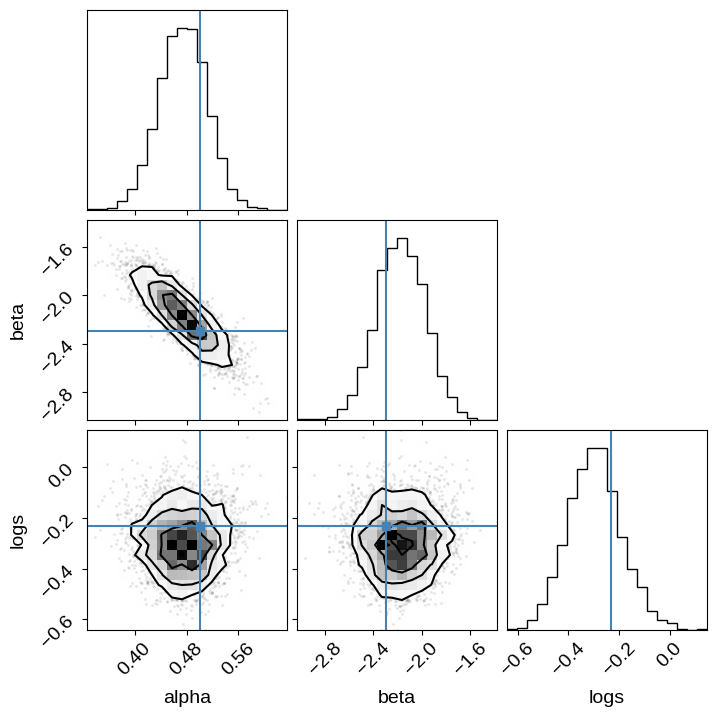

In [3]:
import corner

names = ["alpha", "beta", "logs"]
corner.corner(trace, var_names=names, truths=dict(zip(names, true_params)));

## Sampling the PyMC3 model using emcee

To sample this using emcee, we'll need to do a little bit of bookkeeping.
I've coded this up using version 3 of emcee that is currently available as [the master branch on GitHub](https://github.com/dfm/emcee) or as [a pre-release on PyPI](https://pypi.org/project/emcee/3.0rc1/), so you'll need to install that version to run this.

To sample from this model, we need to expose the Theano method for evaluating the log probability to Python.
There is a version of this built into PyMC3, but I also want to return the values of all the deterministic variables using the ["blobs" feature in emcee](https://emcee.readthedocs.io/en/latest/user/blobs/) so the function is slightly more complicated.

In [4]:
import theano

with model:
    f = theano.function(
        model.vars, [model.logpt] + list(model.vars) + list(model.deterministics)
    )

    def log_prob_func(params):
        dct = model.bijection.rmap(params)
        args = (dct[k.name] for k in model.vars)
        results = f(*args)
        return tuple(results)

And now we can run the sampler:

In [5]:
import emcee

with model:
    # First we work out the shapes of all of the deterministic variables
    res = pm.find_MAP()
    vec = model.bijection.map(res)
    initial_blobs = log_prob_func(vec)[1:]
    dtype = [
        (var.name, float, np.shape(b))
        for var, b in zip(list(model.vars) + list(model.deterministics), initial_blobs)
    ]

    # Then sample as usual
    coords = vec + 1e-5 * np.random.randn(25, len(vec))
    nwalkers, ndim = coords.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func, blobs_dtype=dtype)
    sampler.run_mcmc(coords, 5000, progress=True)

You must install the tqdm library to use progress indicators with emcee


And we can use this to make the same corner plot as above:

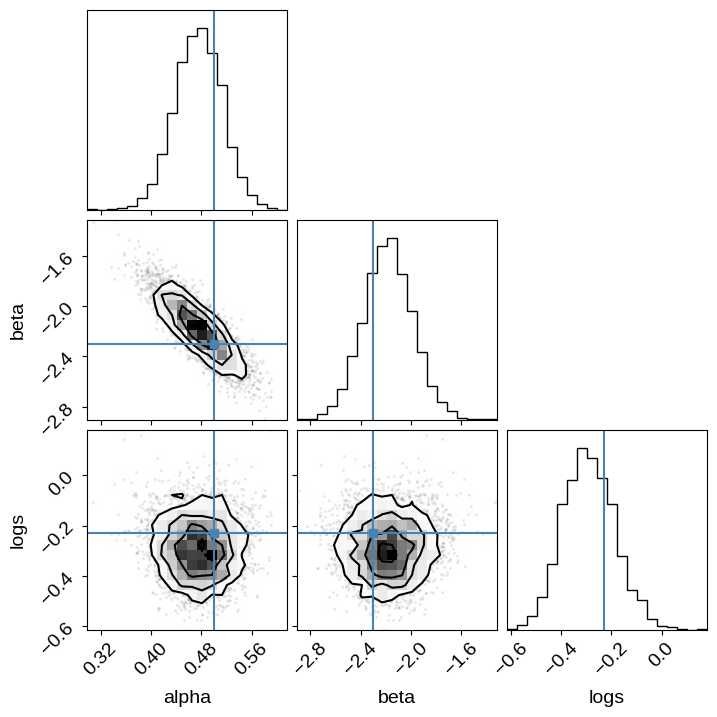

In [6]:
import pandas as pd

df = pd.DataFrame.from_records(sampler.get_blobs(flat=True, discard=100, thin=30))
corner.corner(df[["alpha", "beta", "logs"]], truths=true_params);

The last thing that we might want to look at is [the integrated autocorrelation time](/posts/autocorr/) for each method.
First, as expected, the autocorrelation for PyMC3 is very short (about 1 step):

In [7]:
[
    float(emcee.autocorr.integrated_time(np.array(trace.posterior[var].values).T))
    for var in ["logs", "alphaperp", "theta"]
]

[1.3573344137965568, 1.458729906244515, 1.4597259928196067]

And, the autocorrelation for emcee is about 40 steps:

In [8]:
sampler.get_autocorr_time(discard=100)

array([36.56826715, 38.72133344, 31.81170595])

If you want to compare these results in detail, you'll want to make sure that you take into account the fact that each step of NUTS is significantly more expensive than one step with emcee, but that's way beyond the scope of this post...

*11/22/18: This post has been updated with suggestions from Thomas Wiecki. The `find_MAP` call has been removed from the PyMC sampling, and `model.bijection` is now used to map between arrays and dicts of parameters.*